# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

1- One-hot vectors are sparse and cannot represent relationships or meaning between words, because each word is independent. They also require a lot of space for large vocabularies.

2- It means we learn what a word means by the words it appears with. Words used in similar contexts tend to have similar meanings.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [1]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [3]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mahboobehyasini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahboobehyasini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [4]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])


Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [5]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    tokens= word_tokenize(text.lower())
    tokens=[t for t in tokens if t.isalpha() and t not in stop_words]

    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

1- We remove stopwords to reduce noise and focus on the most meaningful words, which can improve model efficiency and results.
2- Removing stopwords can be a bad idea in tasks like sentiment analysis, where words like “not” change the meaning of a sentence.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [6]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
)

print("Vocabulary size:", len(w2v.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [7]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

w2v.wv["car"][:10]

array([-0.91942304,  1.0881178 ,  0.21173722, -0.47264144, -0.21133079,
       -1.3092287 ,  0.37220713,  1.372125  , -0.923814  , -0.4527646 ],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [8]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")

for word, score in w2v.wv.most_similar(target, topn=20):
    print(f" {word:15s} {score:.3f}")

# YOUR CODE HERE - iterate through the results and print each word and score

Most similar words to 'computer':
 network         0.943
 digital         0.907
 voice           0.905
 products        0.897
 systems         0.895
 design          0.891
 cornerstone     0.888
 software        0.888
 commercial      0.876
 product         0.872
 currently       0.867
 access          0.855
 bbs             0.854
 shopper         0.849
 equipment       0.848
 project         0.844
 remote          0.843
 computers       0.843
 service         0.842
 technology      0.842


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

1- The neighbors mostly show topic similarity, since many words (like network, software, digital, and technology) are related to the computing domain rather than being the same kind of object.
2- A surprising neighbor is “voice”, which may appear because of frequent co-occurrence in contexts like voice recognition, voice commands, or computer voice systems.


---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [9]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

w2v.wv.most_similar
positive=["king","women"],
negative=["men"],
topn=10,


### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [10]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [11]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm
import numpy as np

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))  # YOUR CODE HERE
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.8026


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.


1- Analogy results can be wrong because word meanings depend on context, and not all relationships can be captured perfectly by vectors.
2- Analogy tests may not match task performance because solving analogies is different from doing real tasks like text classification or search.

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

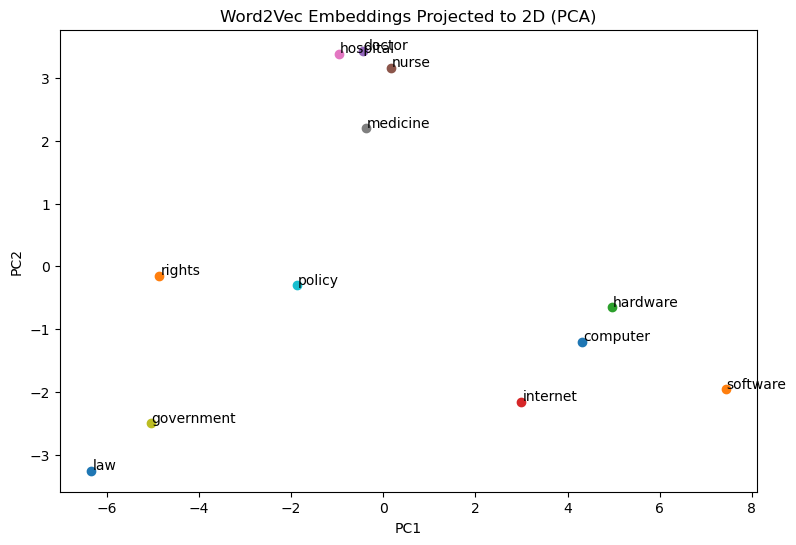

In [12]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

1- The words that are closest together are the ones in the same topic groups: hospital, nurse, doctor, medicine; computer, internet, software, hardware; and law, government, policy, rights.

2- Yes, we can see clusters based on topics: health, technology, and politics. This happens because words that appear in similar contexts tend to be near each other in the embedding space.


---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [13]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
)  # YOUR CODE HERE

print("FastText vocabulary size:", len(ft.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [14]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
# YOUR CODE HERE

# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    # YOUR CODE HERE
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers

Word2Vec neighbors for: computers


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [15]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE
    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    pass

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  (word not in vocabulary)

Query: space
  (word not in vocabulary)

Query: religion
  (word not in vocabulary)

Query: graphics
  (word not in vocabulary)


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

query “hotel”:

1- These neighbors would not help a search engine user if the word is not in the vocabulary, because the system cannot suggest related terms or understand the query.

2- If deployed directly, the search engine could fail to return relevant results or give irrelevant suggestions, leading to a poor user experience.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

1. 
Embeddings represent words as dense vectors instead of sparse one-hot vectors, which reduces memory usage. They also capture meaning because words with similar contexts have similar vectors. This way, the model can understand relationships between words, unlike one-hot vectors where every word is completely separate.

2.
Word embeddings are useful in search engines to find relevant results even if the query words don’t exactly match the documents. They are also used in chatbots, recommendation systems, and sentiment analysis to understand the meaning of text.

3. 
We would choose FastText when you need to handle rare or misspelled words, because it represents words as a combination of character n-grams. This helps it understand words not seen during training, which Word2Vec cannot do.

4. 
Word embeddings can capture biases from the training data, such as gender or racial stereotypes. They may also fail to represent words with multiple meanings correctly, which can lead to wrong predictions in real applications.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [16]:
from gensim.models import FastText

ft_w2 = FastText(
    sentences=corpus,   
    vector_size=100,
    window=2,
    min_count=5,
    workers=4,
    sg=1
)


In [17]:
ft_w2.wv.most_similar("space")


[('spacepac', 0.9555283784866333),
 ('spacehab', 0.950809121131897),
 ('pace', 0.9391133785247803),
 ('airspace', 0.9327222108840942),
 ('aerospace', 0.9116474986076355),
 ('spacewalk', 0.9031251668930054),
 ('spacecraft', 0.8934466242790222),
 ('spaceflight', 0.8828104734420776),
 ('spacelink', 0.8816720247268677),
 ('spacewalks', 0.8739675283432007)]

In [18]:
ft_w10 = FastText(
    sentences=corpus,
    vector_size=100,
    window=10,
    min_count=5,
    workers=4,
    sg=1
)


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [19]:
ft_w10.wv.most_similar("space")


[('spacehab', 0.908790111541748),
 ('spacepac', 0.8870331645011902),
 ('spaced', 0.8591379523277283),
 ('airspace', 0.8565981388092041),
 ('spacewalk', 0.8519610166549683),
 ('aerospace', 0.8447943329811096),
 ('spacecause', 0.8194056749343872),
 ('spacewalks', 0.8193870186805725),
 ('spacelink', 0.8180735111236572),
 ('spaces', 0.8149740099906921)]

In [20]:
ft_cbow = FastText(
    sentences=corpus,
    vector_size=100,
    window=10,
    min_count=5,
    workers=4,
    sg=0   # CBOW
)


In [21]:
ft_cbow.wv.most_similar("space")


[('spacehab', 0.9902512431144714),
 ('pace', 0.9859881401062012),
 ('spacepac', 0.9839996695518494),
 ('airspace', 0.9798699021339417),
 ('spacewalk', 0.975192666053772),
 ('aerospace', 0.9728294610977173),
 ('spacelink', 0.9683447480201721),
 ('spacewalks', 0.9679688811302185),
 ('spacecraft', 0.9620322585105896),
 ('satellite', 0.9555514454841614)]

In [22]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

phrases = Phrases(corpus, min_count=5, threshold=10)
bigram_phraser = Phraser(phrases)

corpus_bigrams = [bigram_phraser[sent] for sent in corpus]


In [23]:
corpus_bigrams[0]


['wondering_anyone',
 'could',
 'enlighten',
 'car',
 'saw',
 'day',
 'sports_car',
 'looked',
 'late',
 'early',
 'called',
 'bricklin',
 'doors',
 'really',
 'small',
 'addition',
 'front_bumper',
 'separate',
 'rest',
 'body',
 'know',
 'anyone',
 'tellme',
 'model',
 'name',
 'engine',
 'specs',
 'years',
 'production',
 'car',
 'made',
 'history',
 'whatever',
 'info',
 'funky',
 'looking',
 'car',
 'please']

In [24]:
# ===== Step 5: Add bigrams before training =====
# Create bigrams
phrases = Phrases(corpus, min_count=5, threshold=10)
bigram_phraser = Phraser(phrases)
corpus_bigrams = [bigram_phraser[sent] for sent in corpus]

# Train FastText on bigram corpus
ft_bigrams = FastText(
    sentences=corpus_bigrams,
    vector_size=100,
    window=10,
    min_count=5,
    workers=4,
    sg=1
)
print("Neighbors for 'sports_car':", ft_bigrams.wv.most_similar("sports_car"))
print("Neighbors for 'front_bumper':", ft_bigrams.wv.most_similar("front_bumper"))


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Neighbors for 'sports_car': [('sportster', 0.8866477012634277), ('sportschannel', 0.8844447731971741), ('sports', 0.8747424483299255), ('sport', 0.8730201125144958), ('sporty', 0.8725850582122803), ('porsche', 0.8508424758911133), ('parking_lot', 0.8479338884353638), ('buyer_pays', 0.8420801162719727), ('honda_civic', 0.8400632739067078), ('nissan', 0.8346253037452698)]
Neighbors for 'front_bumper': [('front_wheel', 0.950089156627655), ('bumper', 0.8854435086250305), ('steering_wheel', 0.8771218061447144), ('front_rear', 0.8729928135871887), ('thicker', 0.8722593188285828), ('bottleneck', 0.871049165725708), ('shifter', 0.8696352243423462), ('front_end', 0.8693749904632568), ('duty_cycle', 0.866544246673584), ('muffler', 0.8659179210662842)]
